In [1]:
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
import io
import logging

In [2]:

# Load dataset
df = pd.read_csv("./dataset/heart.csv")


In [3]:

# Encode categorical features
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [4]:

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [5]:

# Reshape X for RNN input
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


In [6]:
def objective(trial):
    # Define search space for hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    # Build SimpleRNN model
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(SimpleRNN(num_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        elif i == num_layers - 1:
            model.add(SimpleRNN(num_units, activation='relu'))
        else:
            model.add(SimpleRNN(num_units, activation='relu', return_sequences=True))
    
    model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate model on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    return val_acc


In [7]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Get best hyperparameters
best_params = study.best_params

[I 2024-05-23 17:01:57,232] A new study created in memory with name: no-name-17d1b725-a73b-4d14-86b0-c79af66dfb73


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\byomo\AppData\Local\Temp\ipykernel_1776\2956133325.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


[I 2024-05-23 17:02:02,676] Trial 0 finished with value: 0.9130434989929199 and parameters: {'num_layers': 3, 'num_units': 241, 'learning_rate': 0.0007131001971100229}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:02:07,421] Trial 1 finished with value: 0.8985507488250732 and parameters: {'num_layers': 3, 'num_units': 188, 'learning_rate': 0.002579442844990759}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:02:13,574] Trial 2 finished with value: 0.9057971239089966 and parameters: {'num_layers': 3, 'num_units': 95, 'learning_rate': 0.00035051598377212526}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:02:18,150] Trial 3 finished with value: 0.8985507488250732 and parameters: {'num_layers': 1, 'num_units': 238, 'learning_rate': 0.0014856940604273782}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:02:23,180] Trial 4 finished with value: 0.8985507488250732 and parameters: {'num_layers': 1, 'num_units': 118, 'lear

In [8]:
# Train final model with best hyperparameters
final_model = Sequential()
for i in range(best_params['num_layers']):
    if i == 0:
        final_model.add(SimpleRNN(best_params['num_units'], activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    elif i == best_params['num_layers'] - 1:
        final_model.add(SimpleRNN(best_params['num_units'], activation='relu'))
    else:
        final_model.add(SimpleRNN(best_params['num_units'], activation='relu', return_sequences=True))

final_model.add(Dense(1, activation='sigmoid'))  # 1 output neuron for binary classification

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

final_model.fit(X_train, y_train, epochs=15, batch_size=48, verbose=1, validation_data=(X_val, y_val))

# Evaluate final model on test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Predict on test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)

# Print model architecture
final_model.summary()

Epoch 1/15
14/14 [==============================] - 4s 35ms/step - loss: 0.4720 - accuracy: 0.8131 - val_loss: 0.3677 - val_accuracy: 0.8406
Epoch 2/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3593 - accuracy: 0.8567 - val_loss: 0.3412 - val_accuracy: 0.8551
Epoch 3/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3270 - accuracy: 0.8723 - val_loss: 0.3128 - val_accuracy: 0.8623
Epoch 4/15
14/14 [==============================] - 0s 5ms/step - loss: 0.3061 - accuracy: 0.8676 - val_loss: 0.2757 - val_accuracy: 0.9058
Epoch 5/15
14/14 [==============================] - 0s 6ms/step - loss: 0.2911 - accuracy: 0.8738 - val_loss: 0.2945 - val_accuracy: 0.8841
Epoch 6/15
14/14 [==============================] - 0s 5ms/step - loss: 0.2686 - accuracy: 0.8863 - val_loss: 0.2755 - val_accuracy: 0.9203
Epoch 7/15
14/14 [==============================] - 0s 6ms/step - loss: 0.2553 - accuracy: 0.8956 - val_loss: 0.3062 - val_accuracy: 0.8696
Epoch 8/15
14/14 [=

In [9]:
# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy= accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
f1 = f1_score(y_test, y_pred, average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9057971014492754
Precision: 0.926829268292683
Recall: 0.9156626506024096
F1 Score: 0.9212121212121213
ROC AUC Score: 0.9454545454545454


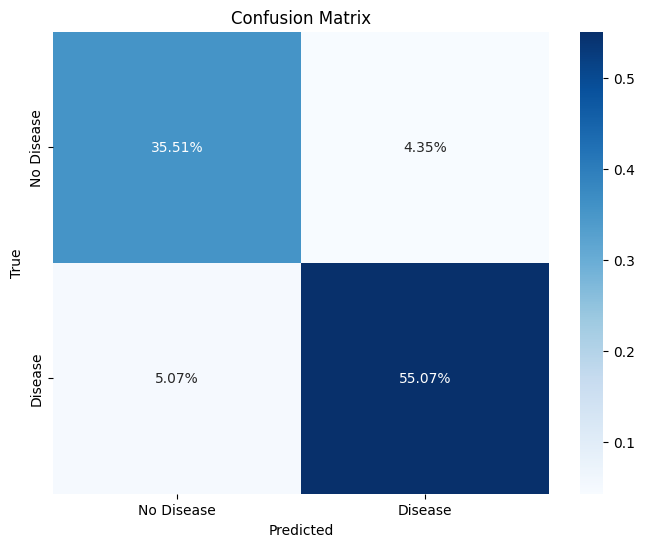

In [10]:
# Plot the confusion matrix using seaborn for better visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        55
           1       0.93      0.92      0.92        83

    accuracy                           0.91       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.91      0.91      0.91       138



## Saving the Model

In [12]:
'''# Save the model
final_model.save('./models/SimpleRNN.h5')'''
